In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df, plot_performance_hist


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    action = np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    
    #if word == 'aargh':
    #    print(f'recons', action, history, guesses)
    return action   
    

def construct_action_vectors_global(arg): #guesses, history, start_idx, end_idx):
    st = time.time()
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    ret = np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    #print(f'construct_actions_global took {time.time() - st}')
    return ret
           
def construct_action_vectors(guesses, history, df):
        return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iterrows()])
    
NUM_PROCESSES = mp.cpu_count() - 1
def construct_action_vectors_mp(guesses, history, df):
        grp_lst_args = []
        grp_guesses = [guesses] * NUM_PROCESSES
        grp_history = [history] * NUM_PROCESSES
        
        chunk_size = int(len(df) / NUM_PROCESSES) + 1
        start_offsets = list(range(0, len(df), chunk_size))
        end_offsets = start_offsets[1:] + [len(df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        pool = mp.Pool(processes=NUM_PROCESSES)
        results = pool.map(construct_action_vectors_global, grp_lst_args)
        pool.close()
        pool.join()
        return np.concatenate(results)
    
    
def construct_state_vector(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))


    

   
so the state is going to be:
* The number of green locations we know
*  The number of other letters we know to be in the word
*  The number of letters we know to not be in the word
*  The sequence number of the guess (1st guess, 2nd guess etc.)

the action is going to be a word that we will submit next
for the purposes of feeding into the model, we will represent the action word as:
*  whether or not it conforms to the hint history
*  how many new letters it gives us
*  the number of uniq letters in the word
*  the frequency of the letters in the word

the reward is going to be:
*  the score improvement (if any) gained on the last guess
*  the score will be calculated as 2 * num_green_letters + num_orange_letters

In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [7]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [8]:
class LinearQ(nn.Module):

    def __init__(self, inputs):
        super(LinearQ, self).__init__()
        self.head = nn.Linear(inputs, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return self.head(x)

In [9]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)

    #for tr in transitions:
    #    print(list(tr.state), list(tr.action), tr.reward)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)
    
    #print(reward_batch)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    print('loss shapes')
    print(state_action_value_estimates.shape)
    print(expected_state_action_values.shape)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #for param in model.parameters():
        #param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [15]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128),
                   seed=0,
                   run_test=False):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = construct_action_vectors(env.guesses, env.history, env.df)
    starting_state = construct_state_vector(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    if model.name == 'linear':
        policy_net = LinearQ(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        guesses = []
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            
            epsilons.append(eps)
            #print(epsilons)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            #print(action_idx, selected_action)
            guesses.append(env.word_from_index(action_idx))
            print(f'------guess {t} {action_idx} {guesses[-1]} {selected_action}-------')
            
            history, reward, done = env.step_by_index(action_idx)
            #here next_state == env.history
            if not done:
                next_state = construct_state_vector(guesses, history)
                actions = construct_action_vectors_mp(guesses, history, env.df)
            
            print(f'reward {reward} done {done} ')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                scores = history.sum(axis=1) # calc the score for each guess from the history
                episode_reward = sum(tr[2] for tr in episode_memory)
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                # reward[i] = max(0, scores[i] - max(scores[0:i-1]))
                
                for i,tr in enumerate(episode_memory):
                    if i == 0:
                        score = scores[i]
                    else:
                        score = max(0, scores[i] - scores[0:i].max())
                    print(f'{guesses[i]} {history[i]} {score}')    
                
                    memory.push(tr[0], tr[1], [score])
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    if run_test:
        performance_hist = [0] * (1 + env.num_guesses)
        for e in env.foreach_target_word():
            state = starting_state
            actions = starting_actions
            done = False
            reward = 0
            guesses = []
            while not done:
                action_idx = select_action(policy_net, state, actions, 0)
                selected_action = actions[action_idx]
                chosen_word = env.word_from_index(action_idx)
                guesses.append(chosen_word)
                history, reward, done = env.step_by_index(action_idx)
                
                if not done:
                    state = construct_state_vector(guesses, history)
                    actions = construct_action_vectors_mp(guesses, history, env.df)
                
            
            if len(guesses) == 6 and reward == -1:
                num_guesses = 0
            else:
                num_guesses = len(guesses)
            print(f'{e.target} {num_guesses}')    
            performance_hist[num_guesses] += 1
        
        for i,p in enumerate(performance_hist):
            print(f'{i}: {p}')
        plot_performance_hist(performance_hist)
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True

reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True 
episode 8 finished.  reward -6  eps 0.0  gamma 0.0  steps 54  memory 48
jumpy [0. 0. 0. 0. 2.] 2.0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11260 

reward -1 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 18 finished.  reward -6  eps 0.0  gamma 0.0  steps 103  memory 97
mamma [0. 1. 0. 2. 0.] 3.0
mamma [0. 1. 0. 2. 0.] 0
mamma [0. 1. 0. 2. 0.] 0
mamma [0. 1. 0. 2. 0.] 0
mamma [0. 1. 0. 2. 0.] 0
mamma [0. 1. 0. 2. 0.] 0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 0.49001291394233704
=========================episode 19 geese======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 1610 chuse [1.         0.6        0.52

reward -1 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward -1 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward -1 done False 
------guess 3 11751 buyer [1.         0.6        0.53609084 0.         0.        ]-------
reward -1 done False 
------guess 4 11806 dryer [1.         0.2        0.6243309  0.33333333 0.        ]-------
reward 0 done True 
episode 30 finished.  reward -4  eps 0.0  gamma 0.0  steps 151  memory 146
later [0. 0. 0. 2. 2.] 4.0
poser [0. 0. 0. 2. 2.] 0
nicer [0. 0. 0. 2. 2.] 0
buyer [0. 0. 2. 2. 2.] 2.0
dryer [2. 2. 2. 2. 2.] 4.0
=========================episode 31 abode======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 10697 adobe [1.         

reward -1 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward -1 done False 
------guess 2 12244 curio [1.         0.4        0.53008921 0.         0.        ]-------
reward -1 done False 
------guess 3 11956 rocky [1.         0.4        0.44849959 0.         0.        ]-------
reward 0 done True 
episode 41 finished.  reward -3  eps 0.0  gamma 0.0  steps 198  memory 194
later [0. 0. 0. 0. 1.] 1.0
scorn [0. 1. 1. 1. 0.] 2.0
curio [1. 0. 1. 0. 1.] 0
rocky [2. 2. 2. 2. 2.] 7.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 0.7734197378158569
=========================episode 42 hater======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10929 cater [1.         0.2        0.70024331 0.         0.        ]-------
reward -1 done False 
------guess 2 11364 hater [1.         0.2        0.68596918 0.         0.        ]-------
reward 0 

reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 11558 since [1.         0.2        0.58799676 0.         0.        ]-------
reward -1 done False 
------guess 3 11285 singe [1.         0.2        0.56107056 0.         0.        ]-------
reward 0 done True 
episode 54 finished.  reward -3  eps 0.0  gamma 0.0  steps 243  memory 239
later [0. 0. 0. 1. 0.] 1.0
noise [1. 0. 1. 1. 2.] 4.0
since [2. 2. 2. 0. 2.] 3.0
singe [2. 2. 2. 2. 2.] 2.0
=========================episode 55 madly======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11628 salon [1.         0.6        0.59951338 0.         0.        ]-------
reward -1 done False 
------guess 2 12601 daily [1.         0.6        0.51695053 0.         0.        ]-------
reward -1 done False 
------guess 3 12832 madly [1.        0.2       0.4593674 0.  

reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 11629 nudge [1.         0.6        0.48321168 0.         0.        ]-------
reward 0 done True 
episode 66 finished.  reward -2  eps 0.0  gamma 0.0  steps 289  memory 286
later [0. 0. 0. 1. 0.] 1.0
noise [2. 0. 0. 0. 2.] 3.0
nudge [2. 2. 2. 2. 2.] 6.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 1.0498234033584595
=========================episode 67 friar======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12523 sonar [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10657 cigar [1.         0.6        0.54128143 0.         0.        ]-------
reward -1 done False 
------guess 3 10792 briar [1.         0.2        0.60486618 0.33333333 0.        ]-------
reward -1 done False 
------guess 

reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 12421 chide [1.         0.6        0.51305758 0.         0.        ]-------
reward -1 done False 
------guess 3 12327 guide [1.         0.4        0.49878345 0.         0.        ]-------
reward 0 done True 
episode 79 finished.  reward -3  eps 0.0  gamma 0.0  steps 336  memory 332
later [0. 0. 0. 1. 0.] 1.0
noise [0. 0. 2. 0. 2.] 3.0
chide [0. 0. 2. 2. 2.] 2.0
guide [2. 2. 2. 2. 2.] 4.0
=========================episode 80 couch======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11713 pouch [1.         0.6        0.39805353 0.         0.        ]-------
reward -1 done False 
------guess 3 11005 vouch [1.         0.2        0.36334144 0

reward -1 done False 
------guess 2 11762 modal [1.         0.6        0.51273317 0.         0.        ]-------
reward -1 done False 
------guess 3 10726 offal [1.         0.2        0.47234388 0.33333333 0.        ]-------
reward 0 done True 
episode 90 finished.  reward -3  eps 0.0  gamma 0.0  steps 383  memory 379
later [1. 1. 0. 0. 0.] 2.0
snail [0. 0. 1. 0. 2.] 1.0
modal [0. 1. 0. 2. 2.] 2.0
offal [2. 2. 2. 2. 2.] 5.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 0.9400404691696167
=========================episode 91 slosh======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11537 solid [1.         0.8        0.52003244 0.         0.        ]-------
reward -1 done False 
------guess 2 12541 scowl [1.         0.4        0.45644769 0.         0.        ]-------
reward -1 done False 
------guess 3 12530 sloop [1.         0.2        0.52927818 0.33333333 0.        ]-------
reward 

reward -1 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward -1 done False 
------guess 2 12130 dusty [1.        0.6       0.4351987 0.        0.       ]-------
reward -1 done False 
------guess 3 11213 musty [1.         0.2        0.42270884 0.         0.        ]-------
reward 0 done True 
episode 103 finished.  reward -3  eps 0.0  gamma 0.0  steps 431  memory 427
later [0. 0. 1. 0. 0.] 1.0
stoic [1. 1. 0. 0. 0.] 1.0
dusty [0. 2. 2. 2. 2.] 6.0
musty [2. 2. 2. 2. 2.] 2.0
=========================episode 104 prime======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward -1 done False 
------guess 3 10687 pride [1.         0.2        0.57793998 0.  

reward -1 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward -1 done False 
------guess 2 11228 count [1.         0.4        0.48694242 0.         0.        ]-------
reward -1 done False 
------guess 3 11774 touch [1.        0.2       0.4567721 0.        0.       ]-------
reward 0 done True 
episode 116 finished.  reward -3  eps 0.0  gamma 0.0  steps 476  memory 472
later [0. 0. 1. 0. 0.] 1.0
stoic [0. 1. 1. 0. 1.] 2.0
count [1. 2. 2. 0. 1.] 3.0
touch [2. 2. 2. 2. 2.] 4.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 0.9539308547973633
=========================episode 117 husky======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11362 pushy [1.         0.8        0.37583131 0.         0.        ]-------
reward -1 

reward -1 done False 
------guess 3 12200 shale [1.         0.2        0.64703974 0.         0.        ]-------
reward 0 done True 
episode 127 finished.  reward -3  eps 0.0  gamma 0.0  steps 521  memory 517
later [1. 1. 0. 1. 0.] 3.0
aisle [1. 0. 1. 2. 2.] 3.0
scale [2. 0. 2. 2. 2.] 2.0
shale [2. 2. 2. 2. 2.] 2.0
=========================episode 128 denim======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 11168 denim [1.         0.4        0.51711273 0.         0.        ]-------
reward 0 done True 
episode 128 finished.  reward -2  eps 0.0  gamma 0.0  steps 524  memory 521
later [0. 0. 0. 1. 0.] 1.0
noise [1. 0. 1. 0. 1.] 2.0
denim [2. 2. 2. 2. 2.] 7.0
=========================episode 129 prowl======================
------guess 0 11530 later [1.         1.         0.73949716 0. 

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11637 unzip [1.         0.6        0.34387672 0.         0.        ]-------
reward 0 done True 
episode 139 finished.  reward -2  eps 0.0  gamma 0.0  steps 568  memory 565
later [0. 0. 0. 0. 0.] 0.0
sonic [0. 0. 1. 2. 0.] 3.0
unzip [2. 2. 2. 2. 2.] 7.0
=========================episode 140 cheer======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward -1 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward -1 done False 
------guess 3 11787 cyber [1.        0.4       0.5377129 0.        0.       ]-------
reward -1 done False 
------guess 4 12363 cheer [1.         0.2        0.68629359 0.33333333 0.        ]-------
r

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11441 dumpy [0.5        1.         0.31922141 0.         0.        ]-------
reward -1 done False 
------guess 3 12204 whiff [0.66666667 0.6        0.27818329 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 11481 scion [1.         0.         0.51030008 0.         0.        ]-------
reward 0 done True 
episode 151 finished.  reward -4  eps 0.0  gamma 0.0  steps 617  memory 612
later [0. 0. 0. 0. 0.] 0.0
sonic [2. 1. 1. 1. 1.] 6.0
dumpy [0. 0. 0. 0. 0.] 0
whiff [0. 0. 2. 0. 0.] 0
scion [2. 2. 2. 2. 2.] 4.0
=========================episode 152 bowel======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12338 olden [1.         0.6        0.59594485 0.         0.        ]-------
reward -1 done False 
------guess 2 10744 golem [1.       

reward -1 done False 
------guess 1 11249 canoe [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 10893 pause [1.        0.6       0.6025953 0.        0.       ]-------
reward -1 done False 
------guess 3 12702 mauve [1.         0.4        0.51062449 0.         0.        ]-------
reward 0 done True 
episode 164 finished.  reward -3  eps 0.0  gamma 0.0  steps 662  memory 658
later [0. 2. 0. 1. 0.] 3.0
canoe [0. 2. 0. 0. 2.] 1.0
pause [0. 2. 2. 0. 2.] 2.0
mauve [2. 2. 2. 2. 2.] 4.0
=========================episode 165 hound======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 12915 hound [1.         0.6        0.41816707 0.         0.        ]-------
reward 0 done True 
episode 165 finished.  reward -2  eps 0.0  gamma 0.0  steps 665  m

reward -1 done False 
------guess 3 11328 idiot [1.         0.2        0.52197891 0.33333333 0.        ]-------
reward 0 done True 
episode 176 finished.  reward -3  eps 0.0  gamma 0.0  steps 706  memory 702
later [0. 0. 1. 0. 0.] 1.0
stoic [0. 1. 1. 1. 0.] 2.0
point [0. 1. 2. 0. 2.] 2.0
idiot [2. 2. 2. 2. 2.] 5.0
=========================episode 177 scant======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11490 stain [1.         0.6        0.58767234 0.         0.        ]-------
reward -1 done False 
------guess 2 12537 scant [1.         0.2        0.55620438 0.         0.        ]-------
reward 0 done True 
episode 177 finished.  reward -2  eps 0.0  gamma 0.0  steps 709  memory 706
later [0. 1. 1. 0. 0.] 2.0
stain [2. 1. 2. 0. 1.] 4.0
scant [2. 2. 2. 2. 2.] 4.0
=========================episode 178 gloat======================
------guess 0 11530 later [1.         1.         0.73949716 0. 

reward -1 done False 
------guess 3 12695 slyly [1.         0.2        0.47964315 0.66666667 0.        ]-------
reward 0 done True 
episode 189 finished.  reward -3  eps 0.0  gamma 0.0  steps 751  memory 747
later [1. 0. 0. 0. 0.] 1.0
solid [2. 0. 1. 0. 0.] 2.0
slung [2. 2. 0. 0. 0.] 1.0
slyly [2. 2. 2. 2. 2.] 6.0
=========================episode 190 trout======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12049 snort [1.         0.6        0.58815896 0.         0.        ]-------
reward -1 done False 
------guess 2 12740 droit [1.         0.4        0.55896188 0.         0.        ]-------
reward -1 done False 
------guess 3 12153 grout [1.         0.4        0.51257097 0.         0.        ]-------
reward -1 done False 
------guess 4 11639 trout [1.         0.         0.58037307 0.33333333 0.        ]-------
reward 0 done True 
episode 190 finished.  reward -4  eps 0.0  gamma 0.0  steps 7

reward -1 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward 0 done True 
episode 201 finished.  reward -2  eps 0.0  gamma 0.0  steps 797  memory 794
later [0. 0. 0. 1. 1.] 2.0
snore [0. 0. 0. 1. 2.] 1.0
price [2. 2. 2. 2. 2.] 7.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 1.059760570526123
=========================episode 202 whine======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 12873 whine [1.         0.4        0.49683698 0.         0.        ]-------
reward 0 done True 
episode 202 finished.  reward -2  eps 0.0  gamma 0.0  steps 800  memory 797
later [0. 0. 0. 1. 0.] 1.0
noise [1. 0. 2. 0. 2.] 4.0
whine [2. 2. 2. 2. 2.] 5.0
=========================episode 203 fresh======================
------guess 0 1

reward -1 done False 
------guess 2 11441 dumpy [1.         1.         0.31922141 0.         0.        ]-------
reward -1 done False 
------guess 3 12621 jumpy [1.         0.2        0.25985401 0.         0.        ]-------
reward 0 done True 
episode 214 finished.  reward -3  eps 0.0  gamma 0.0  steps 843  memory 839
later [0. 0. 0. 0. 0.] 0.0
sonic [0. 0. 0. 0. 0.] 0
dumpy [0. 2. 2. 2. 2.] 8.0
jumpy [2. 2. 2. 2. 2.] 2.0
=========================episode 215 press======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 10853 rebus [1.        0.4       0.5756691 0.        0.       ]-------
reward -1 done False 
------guess 3 11393 cress [1.         0.2        0.64022709 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 12455 dress [1.         0.2        0.62660178 0.3333

reward -1 done False 
------guess 1 10681 stool [1.         0.6        0.58799676 0.33333333 0.        ]-------
reward -1 done False 
------guess 2 11388 tunic [1.         0.8        0.47347932 0.         0.        ]-------
reward -1 done False 
------guess 3 10701 digit [1.         0.4        0.45012165 0.33333333 0.        ]-------
reward 0 done True 
episode 226 finished.  reward -3  eps 0.0  gamma 0.0  steps 891  memory 887
eater [0. 0. 1. 0. 0.] 1.0
stool [0. 1. 0. 0. 0.] 0
tunic [1. 0. 0. 2. 0.] 2.0
digit [2. 2. 2. 2. 2.] 7.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 0.9854925870895386
=========================episode 227 comma======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
reward -1 done False 
------guess 2 11232 mocha [1.         0.6        0.47283049 0.         0.        ]-------
reward 

reward -1 done False 
------guess 1 10929 cater [1.         0.2        0.70024331 0.         0.        ]-------
reward -1 done False 
------guess 2 11364 hater [1.         0.2        0.68596918 0.         0.        ]-------
reward -1 done False 
------guess 3 12308 water [1.         0.2        0.65450122 0.         0.        ]-------
reward 0 done True 
episode 239 finished.  reward -3  eps 0.0  gamma 0.0  steps 937  memory 933
later [0. 2. 2. 2. 2.] 8.0
cater [0. 2. 2. 2. 2.] 0
hater [0. 2. 2. 2. 2.] 0
water [2. 2. 2. 2. 2.] 2.0
=========================episode 240 space======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 11309 chase [1.         0.4        0.60778589 0.         0.        ]-------
reward -1 done False 
------guess 3 11888 space [1.         0.2        0.60421736 0. 

reward -1 done False 
------guess 2 11414 nerve [1.         0.4        0.66390916 0.33333333 0.        ]-------
reward 0 done True 
episode 250 finished.  reward -2  eps 0.0  gamma 0.0  steps 982  memory 979
eerie [0. 2. 2. 0. 2.] 6.0
terse [0. 2. 2. 0. 2.] 0
nerve [2. 2. 2. 2. 2.] 4.0
=========================episode 251 buddy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11869 bunny [1.         0.8        0.37680454 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 11479 buddy [1.         0.2        0.31776156 0.33333333 0.        ]-------
reward 0 done True 
episode 251 finished.  reward -4  eps 0.0  gamma 0.0  steps 987  memory 982
eerie [0. 0. 0

dream 5
stale 3
vomit 4
ombre 4
fanny 6
unite 4
snarl 4
baker 0
there 3
glyph 4
pooch 4
hippy 5
spell 5
folly 0
louse 4
gulch 5
vault 5
godly 0
threw 4
fleet 3
grave 0
inane 3
shock 6
crave 5
spite 4
valve 5
skimp 6
claim 3
rainy 4
musty 5
pique 5
daddy 5
quasi 5
arise 3
aging 4
valet 3
opium 4
avert 4
stuck 6
recut 4
mulch 4
genre 3
plume 4
rifle 4
count 4
incur 4
total 3
wrest 4
mocha 4
deter 3
study 5
lover 6
safer 6
rivet 4
funny 5
smoke 6
mound 5
undue 4
sedan 3
pagan 4
swine 6
guile 4
gusty 6
equip 4
tough 5
canoe 4
chaos 4
covet 5
human 5
udder 6
lunch 4
blast 3
stray 3
manga 4
melee 3
lefty 3
quick 6
paste 5
given 4
octet 3
risen 3
groan 4
leaky 5
grind 5
carve 5
loose 3
sadly 3
spilt 4
apple 4
slack 5
honey 5
final 3
sheen 3
eerie 1
minty 5
slick 6
derby 5
wharf 6
spelt 3
coach 4
erupt 3
singe 5
price 4
spawn 5
fairy 6
jiffy 6
filmy 5
stack 4
chose 4
sleep 3
ardor 3
nanny 4
niece 2
woozy 0
handy 0
grace 4
ditto 3
stank 5
cream 5
usual 3
diode 3
valor 5
angle 4
ninja 4
muddy 0


stoke 4
riper 4
orbit 4
cocoa 3
guilt 4
humus 5
shush 3
table 3
smirk 5
wrong 0
noisy 3
alert 3
shiny 4
elate 2
resin 2
whole 4
hunch 4
pixel 4
polar 4
hotel 3
sword 5
cleat 4
mango 5
rumba 4
puffy 0
filly 0
billy 6
leash 3
clout 5
dance 5
ovate 4
facet 4
chili 5
paint 4
liner 4
curio 3
salty 4
audio 4
snake 5
fable 4
cloak 4
navel 4
spurt 4
pesto 4
balmy 4
flash 5
unwed 6
early 3
churn 5
weedy 5
stump 0
lease 3
witty 6
wimpy 6
spoof 5
saner 4
blend 5
salsa 2
thick 4
warty 6
manic 5
blare 4
squib 5
spoon 5
probe 5
crepe 4
knack 4
force 4
debut 4
order 4
haste 4
teeth 4
agent 4
widen 4
icily 4
slice 4
ingot 4
clash 4
juror 4
blood 4
abode 4
throw 5
unity 4
pivot 4
slept 4
troop 5
spare 0
sewer 3
parse 2
morph 0
cacti 3
tacky 6
spool 4
demon 4
moody 5
annex 4
begin 4
fuzzy 0
patch 0
water 6
lumpy 4
admin 4
omega 5
limit 3
tabby 5
macho 5
aisle 3
skiff 6
basis 4
plank 5
verge 4
botch 5
crawl 4
lousy 3
slain 4
cubic 5
raise 3
wrack 5
guide 6
foist 6
cameo 3
under 4
actor 4
revue 3
fraud 5


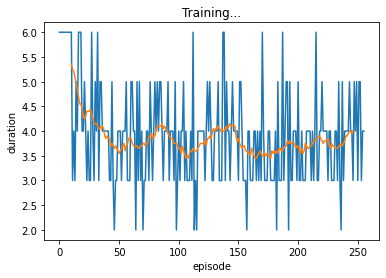

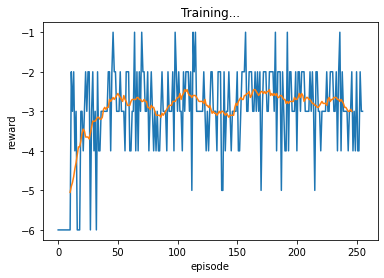

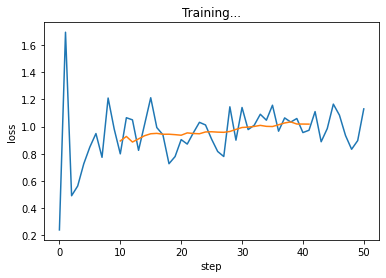

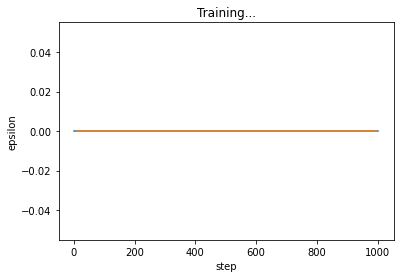

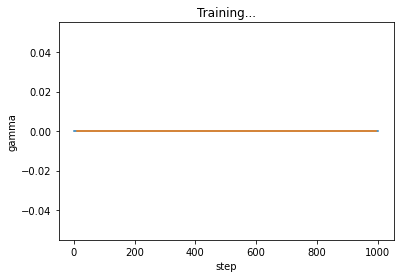

In [11]:

plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=256,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07),
    seed=0,
    run_test=True
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True

reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True 
episode 8 finished.  reward -6  eps 0.0  gamma 0.0  steps 54  memory 48
jumpy [0. 0. 0. 0. 2.] 2.0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11260 

reward -1 done False 
------guess 2 12621 jumpy [0.         0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 12621 jumpy [0.         0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.         0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 12621 jumpy [0.         0.         0.25985401 0.         0.        ]-------
reward -1 done True 
episode 17 finished.  reward -6  eps 0.0  gamma 0.0  steps 106  memory 100
jumpy [0. 0. 0. 0. 0.] 0.0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
jumpy [0. 0. 0. 0. 0.] 0
=========================episode 18 champ======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11210 skimp [1.       0.6      0.362206 0.       0.      ]-------
reward -1 done False 
------guess 2 11210 skimp 

reward -1 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 27 finished.  reward -6  eps 0.0  gamma 0.0  steps 153  memory 147
mamma [0. 0. 0. 0. 0.] 0.0
eerie [0. 0. 0. 0. 2.] 2.0
tooth [0. 2. 0. 0. 0.] 0
poppy [0. 2. 0. 0. 0.] 0
mamma [0. 0. 0. 0. 0.] 0
mamma [0. 0. 0. 0. 0.] 0
=========================episode 28 flier======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12794 mamma [0.33333333 0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 4 

reward -1 done False 
------guess 5 11630 harem [0.4       0.4       0.6189781 0.        0.       ]-------
reward -1 done True 
episode 36 finished.  reward -6  eps 0.0  gamma 0.0  steps 202  memory 196
later [0. 0. 0. 2. 1.] 3.0
risen [1. 0. 0. 2. 0.] 0
corey [2. 0. 1. 2. 0.] 2.0
caper [2. 0. 1. 2. 1.] 1.0
budge [0. 0. 0. 0. 1.] 0
harem [0. 0. 1. 2. 0.] 0
loss shapes
torch.Size([128, 1])
torch.Size([128, 1])
loss 0.49023059010505676
=========================episode 37 chard======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward -1 done False 
------guess 1 426 arils [1.         0.6        0.63860503 0.         1.        ]-------
reward -1 done False 
------guess 2 9719 unary [1.         0.6        0.54257908 0.         1.        ]-------
reward -1 done False 
------guess 3 1525 chark [1.         0.6        0.47915653 0.         1.        ]-------
reward -1 done False 
------guess 4 6766 pharm [0.75      0.4       0.4785077

reward -1 done False 
------guess 3 9141 tawie [0.66666667 0.4        0.61751825 0.         1.        ]-------
reward -1 done False 
------guess 4 9132 taupe [0.75       0.4        0.61232766 0.         1.        ]-------
reward -1 done False 
------guess 5 12216 table [1.         0.2        0.63925385 0.         0.        ]-------
reward 0 done True 
episode 46 finished.  reward -5  eps 0.0  gamma 0.0  steps 252  memory 246
oater [0. 2. 1. 1. 0.] 4.0
taels [2. 2. 1. 2. 0.] 3.0
tache [2. 2. 0. 0. 2.] 0
tawie [2. 2. 0. 0. 2.] 0
taupe [2. 2. 0. 0. 2.] 0
table [2. 2. 2. 2. 2.] 3.0
=========================episode 47 thump======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward -1 done False 
------guess 1 5199 lints [1.         0.8        0.54549878 0.         1.        ]-------
reward -1 done False 
------guess 2 9600 tumpy [1.         0.8        0.37372263 0.         1.        ]-------
reward -1 done False 
------guess 3 2958

reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 11309 chase [1.         0.4        0.60778589 0.         0.        ]-------
reward -1 done False 
------guess 3 10838 peach [1.         0.2        0.55879968 0.         0.        ]-------
reward -1 done False 
------guess 4 11736 beach [1.         0.2        0.54484996 0.         0.        ]-------
reward 0 done True 
episode 56 finished.  reward -4  eps 0.0  gamma 0.0  steps 301  memory 296
later [0. 1. 0. 1. 0.] 2.0
ocean [0. 1. 1. 1. 0.] 1.0
chase [1. 1. 2. 0. 1.] 2.0
peach [0. 2. 2. 2. 2.] 3.0
beach [2. 2. 2. 2. 2.] 2.0
=========================episode 57 light======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10745 lusty [1.         0.6        0.48807786 0.         0.        ]-------
reward -1 done False 
------guess 2 10883 light [1.     

reward -1 done False 
------guess 1 12523 sonar [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10657 cigar [1.         0.6        0.54128143 0.         0.        ]-------
reward -1 done False 
------guess 3 4310 imbar [1.         0.4        0.51030008 0.         1.        ]-------
reward -1 done False 
------guess 4 11685 friar [1.         0.2        0.59659367 0.33333333 0.        ]-------
reward 0 done True 
episode 67 finished.  reward -4  eps 0.0  gamma 0.0  steps 349  memory 344
later [0. 1. 0. 0. 2.] 3.0
sonar [0. 0. 0. 2. 2.] 1.0
cigar [0. 1. 0. 2. 2.] 1.0
imbar [1. 0. 0. 2. 2.] 0
friar [2. 2. 2. 2. 2.] 5.0
=========================episode 68 drain======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10720 drain [1.        

reward -1 done False 
------guess 1 11249 canoe [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 11945 cause [1.         0.4        0.62043796 0.         0.        ]-------
reward -1 done False 
------guess 3 1345 cadie [1.         0.4        0.60875912 0.         1.        ]-------
reward -1 done False 
------guess 4 11994 cache [1.         0.2        0.57664234 0.33333333 0.        ]-------
reward 0 done True 
episode 77 finished.  reward -4  eps 0.0  gamma 0.0  steps 397  memory 392
later [0. 2. 0. 1. 0.] 3.0
canoe [2. 2. 0. 0. 2.] 3.0
cause [2. 2. 0. 0. 2.] 0
cadie [2. 2. 0. 0. 2.] 0
cache [2. 2. 2. 2. 2.] 4.0
=========================episode 78 serif======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 12750 serif [1.         0

reward -1 done False 
------guess 1 12567 stone [1.         0.6        0.64233577 0.         0.        ]-------
reward -1 done False 
------guess 2 11462 edict [1.         0.6        0.56820762 0.         0.        ]-------
reward -1 done False 
------guess 3 11556 eight [1.        0.4       0.5406326 0.        0.       ]-------
reward 0 done True 
episode 88 finished.  reward -3  eps 0.0  gamma 0.0  steps 443  memory 439
later [0. 0. 1. 1. 0.] 2.0
stone [0. 1. 0. 0. 1.] 0
edict [2. 0. 1. 0. 2.] 3.0
eight [2. 2. 2. 2. 2.] 5.0
=========================episode 89 shack======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
reward -1 done False 
------guess 2 11683 shady [1.         0.8        0.46309813 0.         0.        ]-------
reward -1 done False 
------guess 3 12103 shack [1.         0.4        0.44184915 0.      

reward -1 done False 
------guess 2 11245 guile [1.         0.6        0.55166261 0.         0.        ]-------
reward -1 done False 
------guess 3 12472 bulge [1.         0.2        0.48840227 0.         0.        ]-------
reward 0 done True 
episode 100 finished.  reward -3  eps 0.0  gamma 0.0  steps 489  memory 485
later [1. 0. 0. 1. 0.] 2.0
close [0. 1. 0. 0. 2.] 1.0
guile [1. 2. 0. 1. 2.] 3.0
bulge [2. 2. 2. 2. 2.] 4.0
=========================episode 101 harem======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11828 ramen [1.         0.4        0.64914842 0.         0.        ]-------
reward -1 done False 
------guess 2 11630 harem [1.        0.2       0.6189781 0.        0.       ]-------
reward 0 done True 
episode 101 finished.  reward -2  eps 0.0  gamma 0.0  steps 492  memory 489
later [0. 2. 0. 2. 1.] 5.0
ramen [1. 2. 1. 2. 0.] 1.0
harem [2. 2. 2. 2. 2.] 4.0
loss shapes
torch.Siz

reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward 0 done True 
episode 113 finished.  reward -1  eps 0.0  gamma 0.0  steps 536  memory 534
later [0. 1. 0. 1. 0.] 2.0
ocean [2. 2. 2. 2. 2.] 8.0
=========================episode 114 color======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12053 flour [1.         0.6        0.49781022 0.         0.        ]-------
reward -1 done False 
------guess 2 12443 color [1.         0.2        0.58442822 0.33333333 0.        ]-------
reward 0 done True 
episode 114 finished.  reward -2  eps 0.0  gamma 0.0  steps 539  memory 536
later [1. 0. 0. 0. 2.] 3.0
flour [0. 1. 1. 0. 2.] 1.0
color [2. 2. 2. 2. 2.] 6.0
=========================episode 115 flirt======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
-----

reward -1 done False 
------guess 1 12917 tonal [1.         0.4        0.60924574 0.         0.        ]-------
reward -1 done False 
------guess 2 11033 gloat [1.         0.2        0.56642336 0.         0.        ]-------
reward -1 done False 
------guess 3 11880 bloat [1.         0.2        0.56155718 0.         0.        ]-------
reward -1 done False 
------guess 4 11024 float [1.         0.2        0.55328467 0.         0.        ]-------
reward 0 done True 
episode 126 finished.  reward -4  eps 0.0  gamma 0.0  steps 585  memory 580
later [1. 1. 1. 0. 0.] 3.0
tonal [1. 1. 0. 2. 1.] 2.0
gloat [0. 2. 2. 2. 2.] 3.0
bloat [0. 2. 2. 2. 2.] 0
float [2. 2. 2. 2. 2.] 2.0
=========================episode 127 shale======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12315 aisle [1.         0.4        0.69278183 0.         0.        ]-------
reward -1 done False 
------guess 2 12349 scale [1.     

reward -1 done False 
------guess 1 11490 stain [1.         0.6        0.58767234 0.         0.        ]-------
reward -1 done False 
------guess 2 11291 stack [1.         0.4        0.49699919 0.         0.        ]-------
reward -1 done False 
------guess 3 11357 stamp [1.         0.4        0.49635036 0.         0.        ]-------
reward -1 done False 
------guess 4 12883 stash [1.         0.2        0.55717762 0.33333333 0.        ]-------
reward -1 done False 
------guess 5 10691 staff [1.         0.2        0.46017843 0.33333333 0.        ]-------
reward 0 done True 
episode 138 finished.  reward -5  eps 0.0  gamma 0.0  steps 633  memory 627
later [0. 1. 1. 0. 0.] 2.0
stain [2. 2. 2. 0. 0.] 4.0
stack [2. 2. 2. 0. 0.] 0
stamp [2. 2. 2. 0. 0.] 0
stash [2. 2. 2. 0. 0.] 0
staff [2. 2. 2. 2. 2.] 4.0
=========================episode 139 unzip======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess

reward -1 done False 
------guess 3 10855 truss [1.         0.         0.5568532  0.33333333 0.        ]-------
reward 0 done True 
episode 149 finished.  reward -3  eps 0.0  gamma 0.0  steps 677  memory 673
later [0. 0. 1. 0. 1.] 2.0
snort [1. 0. 0. 1. 1.] 1.0
rusty [1. 1. 1. 1. 0.] 1.0
truss [2. 2. 2. 2. 2.] 6.0
Complete
cigar 3
rebut 5
sissy 4
humph 4
awake 5
blush 4
focal 4
evade 4
naval 4
serve 4
heath 6
dwarf 4
model 3
karma 4
stink 4
grade 5
quiet 3
bench 3
abate 5
feign 5
major 4
death 5
fresh 4
crust 3
stool 3
colon 3
abase 5
marry 4
react 3
batty 5
pride 4
floss 4
helix 4
croak 3
staff 6
paper 4
unfed 4
whelp 4
trawl 3
outdo 3
adobe 3
crazy 5
sower 4
repay 4
digit 4
crate 3
cluck 5
spike 4
mimic 4
pound 4
maxim 5
linen 3
unmet 3
flesh 3
booby 5
forth 4
first 4
stand 3
belly 5
ivory 3
seedy 4
print 3
yearn 3
drain 3
bribe 6
stout 5
panel 2
crass 4
flume 5
offal 4
agree 2
error 3
swirl 3
argue 3
bleed 5
delta 4
flick 4
totem 3
wooer 0
front 3
shrub 4
parry 5
biome 3
lapel 3
sta

earth 2
storm 4
until 2
taper 2
enter 3
child 3
adopt 4
minor 3
fatty 6
husky 4
brave 0
filet 3
slime 4
glint 3
tread 3
steal 3
regal 3
guest 4
every 5
murky 4
share 5
spore 5
hoist 3
buxom 4
inner 5
otter 4
dimly 3
level 3
sumac 3
donut 3
stilt 4
arena 3
sheet 3
scrub 4
fancy 5
slimy 4
pearl 3
silly 4
porch 4
dingo 3
sepia 4
amble 5
shady 3
bread 4
friar 5
reign 3
dairy 3
quill 4
cross 3
brood 4
tuber 4
shear 2
posit 3
blank 5
villa 4
shank 3
piggy 4
freak 5
which 4
among 4
fecal 5
shell 4
would 4
algae 4
large 2
rabbi 4
agony 3
amuse 4
bushy 5
copse 4
swoon 4
knife 4
pouch 3
ascot 3
plane 3
crown 3
urban 4
snide 3
relay 3
abide 4
viola 3
rajah 5
straw 5
dilly 3
crash 3
amass 5
third 3
trick 4
tutor 2
woody 5
blurb 4
grief 4
disco 3
where 4
sassy 5
beach 5
sauna 4
comic 3
clued 4
creep 4
caste 2
graze 0
snuff 4
frock 4
gonad 4
drunk 4
prong 4
lurid 3
steel 3
halve 4
buyer 4
vinyl 4
utile 3
smell 5
adage 4
worry 4
tasty 5
local 3
trade 4
finch 4
ashen 2
modal 3
gaunt 5
clove 4
enact 3


surge 3
gleam 5
belle 4
salvo 3
crush 4
fruit 4
sappy 5
taker 4
tract 5
ovine 4
spiky 3
frank 6
reedy 4
filth 3
spasm 4
heave 5
mambo 4
right 3
clank 4
trust 4
lumen 3
borne 3
spook 5
sauce 3
amber 4
lathe 2
carat 3
corer 0
dirty 3
slyly 4
affix 4
alloy 4
taint 5
sheep 4
kinky 5
wooly 4
mauve 4
flung 4
yacht 4
fried 5
quail 3
brunt 5
grimy 3
curvy 4
cagey 3
rinse 3
deuce 4
state 6
grasp 4
milky 4
bison 3
graft 4
sandy 3
baste 5
flask 4
hedge 4
girly 3
swash 6
boney 5
coupe 3
endow 4
abhor 3
welch 4
blade 5
tight 0
geese 3
miser 3
mirth 4
cloud 3
cabal 4
leech 3
close 2
tenth 4
pecan 3
droit 3
grail 3
clone 3
guise 3
ralph 3
tango 3
biddy 5
smith 3
mower 5
payee 4
serif 3
drape 4
fifth 5
spank 3
glaze 5
allot 4
truck 4
kayak 6
virus 5
testy 5
tepee 5
fully 6
zonal 3
metro 2
curry 4
grand 3
banjo 3
axion 3
bezel 0
occur 3
chain 3
nasal 3
gooey 5
filer 3
brace 5
allay 5
pubic 3
raven 3
plead 4
gnash 3
flaky 4
munch 4
dully 3
eking 4
thing 4
slink 4
hurry 4
theft 4
shorn 3
pygmy 4
ranch 4


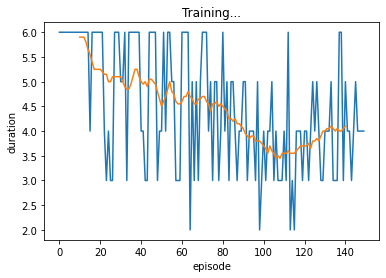

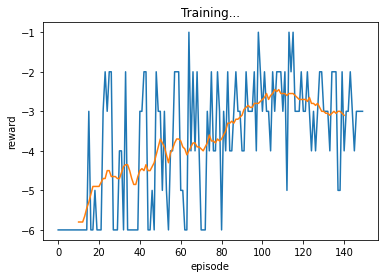

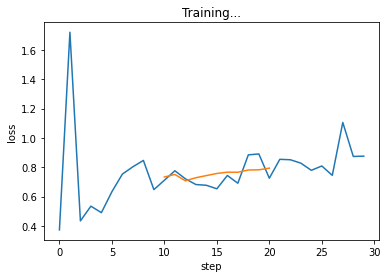

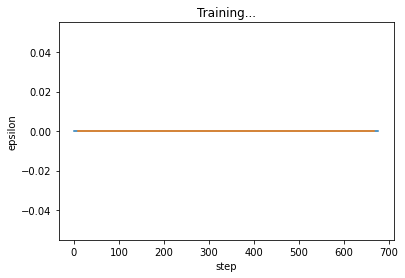

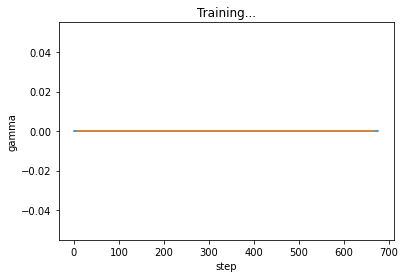

In [12]:

plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=128, clear_memory=False, lr=0.07),
    seed=0,
    run_test=True
    ))

pn params [Parameter containing:
tensor([[ 0.1377, -0.1180, -0.0518,  0.1254, -0.2516,  0.1603, -0.0550,  0.1360,
          0.0372, -0.0327,  0.0741,  0.0132,  0.0976, -0.1042]],
       requires_grad=True), Parameter containing:
tensor([-0.0195], requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 11277 eerie [0.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 12760 tepee [0.         0.4        0.77777778 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12731 geese [0.         0.4        0.75896188 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 12668 belle [0.         0.4        0.67883212 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True

reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.4        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.4        0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 8 finished.  reward -6  eps 0.0  gamma 0.0  steps 54  memory 48
mamma [0. 1. 0. 0. 0.] 1.0
eerie [0. 0. 1. 0. 2.] 2.0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
puppy [0. 1. 0. 0. 0.] 0
mamma [0. 1. 0. 0. 0.] 0
=========================episode 9 wispy======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 12514 rarer [0.         0.4        0.79626926 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 1279

reward -1 done False 
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
reward -1 done False 
------guess 2 12695 slyly [1.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 1728 cocco [1.         0.4        0.47672344 1.         1.        ]-------
reward -1 done False 
------guess 4 12835 known [1.         0.6        0.37453366 0.33333333 0.        ]-------
reward 0 done True 
episode 17 finished.  reward -4  eps 0.0  gamma 0.0  steps 107  memory 102
eerie [0. 0. 0. 0. 0.] 0.0
taata [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
cocco [0. 1. 0. 0. 0.] 1.0
known [2. 2. 2. 2. 2.] 9.0
=========================episode 18 utile======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]-------
reward -1 done False 
------guess 2 313 anana [0.         0.4 

reward -1 done False 
------guess 2 8831 stott [1.         0.4        0.58556367 0.66666667 1.        ]-------
reward -1 done False 
------guess 3 8417 slily [0.66666667 0.6        0.51954582 0.33333333 1.        ]-------
reward -1 done False 
------guess 4 1728 cocco [0.25       0.2        0.47672344 1.         1.        ]-------
reward -1 done False 
------guess 5 8823 stonn [0.8        0.2        0.53560422 0.33333333 1.        ]-------
reward -1 done True 
episode 27 finished.  reward -6  eps 0.0  gamma 0.0  steps 156  memory 150
areae [0. 0. 0. 0. 0.] 0.0
susus [2. 0. 0. 0. 0.] 2.0
stott [2. 2. 2. 0. 0.] 4.0
slily [2. 0. 0. 0. 2.] 0
cocco [0. 1. 0. 0. 0.] 0
stonn [2. 2. 2. 2. 0.] 2.0
loss shapes
torch.Size([64, 1])
torch.Size([64, 1])
loss 1.0205141305923462
=========================episode 28 octet======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12824 latte [1.         0.6        0

reward -1 done False 
------guess 1 1 aalii [1.         0.4        0.65190592 0.66666667 1.        ]-------
reward -1 done False 
------guess 2 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward 0 done True 
episode 36 finished.  reward -2  eps 0.0  gamma 0.0  steps 203  memory 200
eerie [0. 0. 0. 2. 0.] 2.0
aalii [0. 0. 0. 2. 0.] 0
stoic [2. 2. 2. 2. 2.] 8.0
=========================episode 37 opera======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 401 arear [1.         0.2        0.80924574 0.66666667 1.        ]-------
reward -1 done False 
------guess 2 12020 clear [1.         0.4        0.69862125 0.         0.        ]-------
reward -1 done False 
------guess 3 12651 opera [1.        0.4       0.6864558 0.        0.       ]-------
reward 0 done True 
episode 37 finished.  reward -3  eps 0.0  gamma 0.0  steps 207  memory 203
eerie [1. 0. 1. 0. 0.] 2.0
a

reward -1 done False 
------guess 1 237 aline [1.         0.6        0.67753447 0.         1.        ]-------
reward -1 done False 
------guess 2 8494 snead [1.        0.4       0.6243309 0.        1.       ]-------
reward -1 done False 
------guess 3 10781 enema [1.         0.2        0.70332522 0.33333333 0.        ]-------
reward 0 done True 
episode 47 finished.  reward -3  eps 0.0  gamma 0.0  steps 255  memory 251
oater [0. 1. 0. 1. 0.] 2.0
aline [1. 0. 0. 1. 1.] 1.0
snead [0. 2. 2. 1. 0.] 2.0
enema [2. 2. 2. 2. 2.] 5.0
=========================episode 48 stole======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward -1 done False 
------guess 1 9191 teloi [1.         0.4        0.66601784 0.         1.        ]-------
reward -1 done False 
------guess 2 1697 clote [1.         0.2        0.63454988 0.         1.        ]-------
reward -1 done False 
------guess 3 11875 stole [1.         0.2        0.66569343 0.         0

reward -1 done False 
------guess 3 1612 chyle [1.         0.4        0.52603406 0.         1.        ]-------
reward -1 done False 
------guess 4 11396 cycle [1.         0.         0.54030819 0.33333333 0.        ]-------
reward 0 done True 
episode 57 finished.  reward -4  eps 0.0  gamma 0.0  steps 303  memory 298
oater [0. 0. 0. 1. 0.] 1.0
elsin [1. 1. 0. 0. 0.] 1.0
dulce [0. 0. 1. 1. 2.] 2.0
chyle [2. 0. 1. 2. 2.] 3.0
cycle [2. 2. 2. 2. 2.] 3.0
=========================episode 58 upper======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward -1 done False 
------guess 1 8273 siler [1.         0.6        0.67980535 0.         1.        ]-------
reward -1 done False 
------guess 2 6274 nuder [1.         0.6        0.57858881 0.         1.        ]-------
reward -1 done False 
------guess 3 9700 umber [1.         0.4        0.51841038 0.         1.        ]-------
reward -1 done False 
------guess 4 9813 urger [1.         0.

reward -1 done False 
------guess 3 12563 vague [1.         0.4        0.50981346 0.         0.        ]-------
reward 0 done True 
episode 67 finished.  reward -3  eps 0.0  gamma 0.0  steps 350  memory 346
later [0. 2. 0. 1. 0.] 3.0
canoe [0. 2. 0. 0. 2.] 1.0
pause [0. 2. 1. 0. 2.] 1.0
vague [2. 2. 2. 2. 2.] 5.0
=========================episode 68 rayon======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10812 radio [1.         0.6        0.59951338 0.         0.        ]-------
reward -1 done False 
------guess 2 12946 rayon [1.        0.4       0.5891322 0.        0.       ]-------
reward 0 done True 
episode 68 finished.  reward -2  eps 0.0  gamma 0.0  steps 353  memory 350
later [0. 2. 0. 0. 1.] 3.0
radio [2. 2. 0. 0. 1.] 2.0
rayon [2. 2. 2. 2. 2.] 5.0
=========================episode 69 leash======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0

reward -1 done False 
------guess 1 12567 stone [1.         0.6        0.64233577 0.         0.        ]-------
reward -1 done False 
------guess 2 11462 edict [1.         0.6        0.56820762 0.         0.        ]-------
reward -1 done False 
------guess 3 11924 debit [1.         0.2        0.53641525 0.         0.        ]-------
reward 0 done True 
episode 80 finished.  reward -3  eps 0.0  gamma 0.0  steps 397  memory 393
later [0. 0. 1. 1. 0.] 2.0
stone [0. 1. 0. 0. 1.] 0
edict [1. 1. 1. 0. 2.] 3.0
debit [2. 2. 2. 2. 2.] 5.0
=========================episode 81 mummy======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11441 dumpy [1.         1.         0.31922141 0.         0.        ]-------
reward -1 done False 
------guess 3 12861 gummy [1.         0.2        0.29764801 0.3

reward -1 done False 
------guess 1 12338 olden [1.         0.6        0.59594485 0.         0.        ]-------
reward -1 done False 
------guess 2 1676 clies [1.         0.6        0.61135442 0.         1.        ]-------
reward -1 done False 
------guess 3 3589 gluey [1.         0.6        0.51175994 0.         1.        ]-------
reward -1 done False 
------guess 4 12853 bleep [1.         0.4        0.6217356  0.33333333 0.        ]-------
reward 0 done True 
episode 93 finished.  reward -4  eps 0.0  gamma 0.0  steps 445  memory 440
later [1. 0. 0. 2. 0.] 3.0
olden [0. 2. 0. 2. 0.] 1.0
clies [0. 2. 0. 2. 0.] 0
gluey [0. 2. 0. 2. 0.] 0
bleep [2. 2. 2. 2. 2.] 6.0
=========================episode 94 rural======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11190 snarl [1.         0.4        0.62303325 0.         0.        ]-------
reward -1 done False 
------guess 2 11827 coral [1.         0.

reward -1 done False 
------guess 1 11138 saint [1.         0.6        0.58767234 0.         0.        ]-------
reward -1 done False 
------guess 2 11958 waist [1.         0.2        0.52603406 0.         0.        ]-------
reward 0 done True 
episode 105 finished.  reward -2  eps 0.0  gamma 0.0  steps 490  memory 487
later [0. 2. 1. 0. 0.] 3.0
saint [1. 2. 2. 0. 2.] 4.0
waist [2. 2. 2. 2. 2.] 3.0
=========================episode 106 verve======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward -1 done False 
------guess 3 11084 rhyme [1.         0.6        0.52911598 0.         0.        ]-------
reward -1 done False 
------guess 4 12319 verge [1.         0.4        0.62108678 0.33333333 0.        ]----

reward -1 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward -1 done False 
------guess 2 11182 aloud [1.         0.6        0.53722628 0.         0.        ]-------
reward -1 done False 
------guess 3 12697 alloy [1.         0.2        0.58329278 0.33333333 0.        ]-------
reward 0 done True 
episode 118 finished.  reward -3  eps 0.0  gamma 0.0  steps 538  memory 534
later [1. 1. 0. 0. 0.] 2.0
snail [0. 0. 1. 0. 1.] 0
aloud [2. 2. 1. 0. 0.] 3.0
alloy [2. 2. 2. 2. 2.] 5.0
=========================episode 119 smirk======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward -1 done False 
------guess 2 11864 shirk [1.         0.6        0.46034063 0.         0.        ]-------
reward -1 done False 
------guess 3 12217 smirk [1.         0.2        0.44849959 0

reward -1 done False 
------guess 4 11279 slick [1.         0.4        0.44541768 0.         0.        ]-------
reward 0 done True 
episode 130 finished.  reward -4  eps 0.0  gamma 0.0  steps 583  memory 578
later [1. 0. 0. 0. 0.] 1.0
solid [2. 0. 1. 1. 0.] 3.0
sling [2. 2. 2. 0. 0.] 2.0
slimy [2. 2. 2. 0. 0.] 0
slick [2. 2. 2. 2. 2.] 4.0
=========================episode 131 snuff======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 12181 spunk [1.         0.6        0.37112733 0.         0.        ]-------
reward -1 done False 
------guess 3 11743 snuff [1.         0.2        0.35214923 0.33333333 0.        ]-------
reward 0 done True 
episode 131 finished.  reward -3  eps 0.0  gamma 0.0  steps 587  memory 583
later [0. 0. 0. 0. 0.] 0.0
sonic [2. 0. 1. 0. 0.] 3.0
spunk [2. 0. 2. 1.

reward -1 done False 
------guess 1 11767 roast [1.         0.4        0.65369019 0.         0.        ]-------
reward -1 done False 
------guess 2 10984 train [1.         0.4        0.62497972 0.         0.        ]-------
reward 0 done True 
episode 142 finished.  reward -2  eps 0.0  gamma 0.0  steps 630  memory 627
later [0. 1. 1. 0. 1.] 3.0
roast [1. 0. 2. 0. 1.] 1.0
train [2. 2. 2. 2. 2.] 6.0
=========================episode 143 blade======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12315 aisle [1.         0.4        0.69278183 0.         0.        ]-------
reward -1 done False 
------guess 2 11715 plane [1.         0.4        0.62822384 0.         0.        ]-------
reward -1 done False 
------guess 3 12206 glade [1.         0.4        0.58961882 0.         0.        ]-------
reward -1 done False 
------guess 4 12729 blade [1.         0.2        0.58475264 0.         0.        ]----

foray 4
scare 4
stair 2
black 4
squad 4
royal 4
chunk 3
mince 3
slave 3
shame 5
cheek 4
ample 4
flair 3
foyer 6
cargo 4
oxide 3
plant 4
olive 3
inert 3
askew 3
heist 3
shown 4
zesty 4
hasty 3
trash 3
fella 4
larva 2
forgo 4
story 3
hairy 4
train 3
homer 4
badge 5
midst 4
canny 5
fetus 4
butch 4
farce 3
slung 3
tipsy 3
metal 3
yield 3
delve 4
being 4
scour 2
glass 5
gamer 5
scrap 4
money 4
hinge 4
album 4
vouch 4
asset 2
tiara 4
crept 4
bayou 3
atoll 3
manor 2
creak 4
showy 3
phase 4
froth 4
depth 4
gloom 4
flood 5
trait 5
girth 5
piety 4
payer 4
goose 6
float 5
donor 4
atone 2
primo 3
apron 3
blown 4
cacao 3
loser 2
input 4
gloat 3
awful 4
brink 5
smite 5
beady 5
rusty 3
retro 3
droll 5
gawky 4
hutch 5
pinto 4
gaily 4
egret 4
lilac 3
sever 6
field 4
fluff 5
hydro 3
flack 5
agape 4
wench 4
voice 3
stead 3
stalk 4
berth 4
madam 4
night 4
bland 4
liver 4
wedge 5
augur 4
roomy 4
wacky 4
flock 5
angry 3
bobby 5
trite 6
aphid 3
tryst 5
midge 4
power 4
elope 4
cinch 6
motto 3
stomp 4
upset 3


cedar 3
dirge 5
grown 4
horde 3
drool 4
shuck 3
crypt 4
cumin 3
stock 3
gravy 5
locus 2
wider 4
breed 5
quite 4
chafe 4
cache 4
blimp 4
deign 4
fiend 4
logic 3
cheap 3
elide 4
rigid 4
false 2
renal 2
pence 5
rowdy 5
shoot 4
blaze 6
envoy 4
posse 5
brief 5
never 5
abort 3
mouse 4
mucky 4
sulky 3
fiery 3
media 4
trunk 3
yeast 3
clear 2
skunk 4
scalp 5
bitty 4
cider 4
koala 4
duvet 4
segue 3
creme 5
super 3
grill 4
after 2
owner 3
ember 5
reach 4
nobly 3
empty 4
speed 4
gipsy 3
recur 3
smock 4
dread 5
merge 5
burst 4
kappa 4
amity 3
shaky 4
hover 5
carol 2
snort 2
synod 3
faint 4
haunt 4
flour 2
chair 3
detox 3
shrew 4
tense 3
plied 3
quark 5
burly 3
novel 3
waxen 4
stoic 2
jerky 5
blitz 3
beefy 5
lyric 2
hussy 5
towel 3
quilt 6
below 4
bingo 4
wispy 4
brash 4
scone 3
toast 5
easel 6
saucy 4
value 3
spice 3
honor 5
route 3
sharp 5
bawdy 4
radii 3
skull 4
phony 3
issue 4
lager 3
swell 6
urine 3
gassy 4
trial 2
flora 3
upper 5
latch 2
wight 6
brick 4
retry 3
holly 4
decal 4
grass 5
shack 4


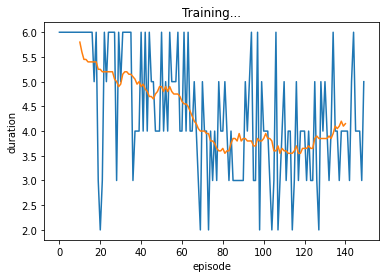

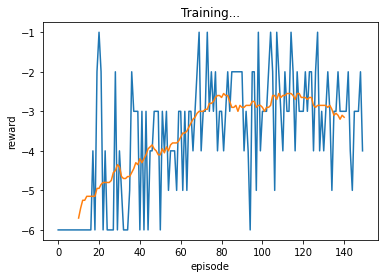

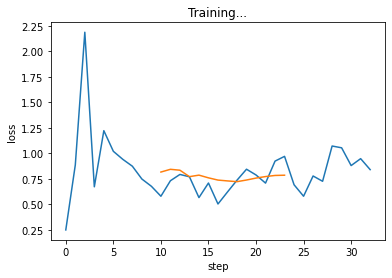

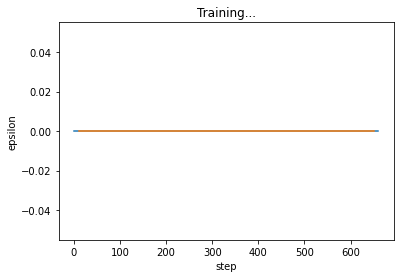

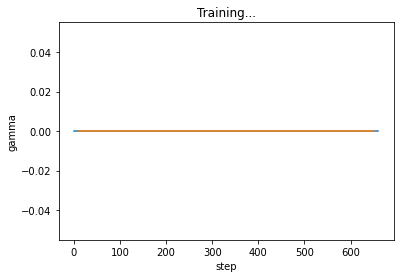

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=512,
    training=TrainConfig(train_interval=32, batch_size=128, clear_memory=True, lr=0.07),
    seed=1,
    run_test=True))

In [16]:
performance_hist

NameError: name 'performance_hist' is not defined